# Laboratorio 04 - Procesamiento de Lenguaje Natural (NLP)

Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

import nltk
from nltk.corpus import opinion_lexicon

### Importación de Datos

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

### Pre-procesamiento

#### Secuenciación y relleno de críticas

In [3]:
X_train = sequence.pad_sequences(X_train, maxlen = 80)
X_test = sequence.pad_sequences(X_test, maxlen = 80)

#### Extracción de features

##### Longitud de la crítica

In [4]:
train_len = [len(x) for x in X_train]
test_len = [len(x) for x in X_test]

##### Ratio de palabras positivas/negativas

In [5]:
##############################################
#      DESCARGA DE CORPUS DE OPINIONES
# OJO: Solo se descarga una vez
# Descomentar SOLO si no se tiene descargado
# nltk.download('opinion_lexicon')
##############################################

In [6]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [7]:
word_index = imdb.get_word_index()
index_to_word = {index: word for word, index in word_index.items()}

In [8]:
# Función para convertir una secuencia de índices a palabras
def decode_review(review):
    return [index_to_word.get(i - 3, '?') for i in review]

In [9]:
# Función para calcular proporción de palabras positivas/negativas en críticas decodificadas
def calculate_word_proportion(review, word_list):
    review_words = decode_review(review)
    count = sum([1 for word in review_words if word in word_list])
    return count / len(review_words) if len(review_words) > 0 else 0

In [10]:
positive_proportions_train = [calculate_word_proportion(x, positive_words) for x in X_train]
negative_proportions_train = [calculate_word_proportion(x, negative_words) for x in X_train]

In [11]:
positive_proportions_test = [calculate_word_proportion(x, positive_words) for x in X_test]
negative_proportions_test = [calculate_word_proportion(x, negative_words) for x in X_test]

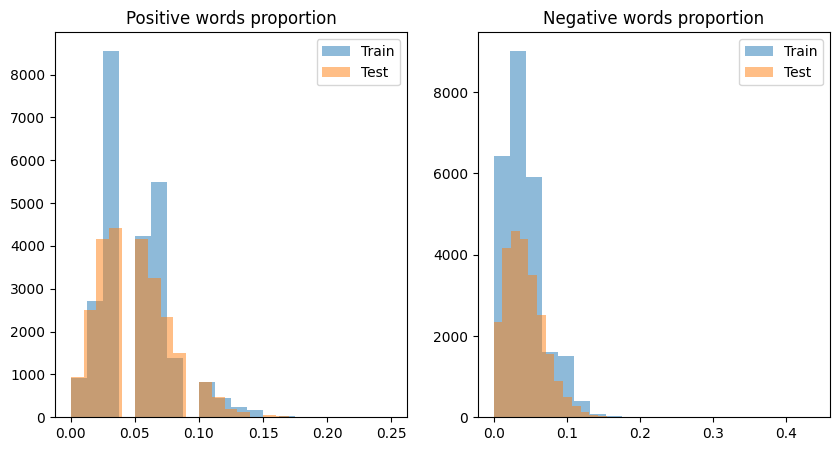

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(positive_proportions_train, bins=20, alpha=0.5, label='Train')
plt.hist(positive_proportions_test, bins=20, alpha=0.5, label='Test')
plt.title('Positive words proportion')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(negative_proportions_train, bins=20, alpha=0.5, label='Train')
plt.hist(negative_proportions_test, bins=20, alpha=0.5, label='Test')
plt.title('Negative words proportion')
plt.legend()